In [2]:
import pygame
import os
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt
from matplotlib import animation
from collections import deque

script_dir = os.path.join(os.getcwd(), 'space_ship_game_RL')
if script_dir not in sys.path:
    sys.path.append(script_dir)

from setting import *
from game import Game

pygame 2.2.0 (SDL 2.32.54, Python 3.11.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
print(torch.cuda.is_available())  # 應該為 True
print(torch.version.cuda)         # 應該列出 CUDA 版本
print(torch.backends.cudnn.version())  # cuDNN 版本
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

True
11.8
90100
Using device: cuda


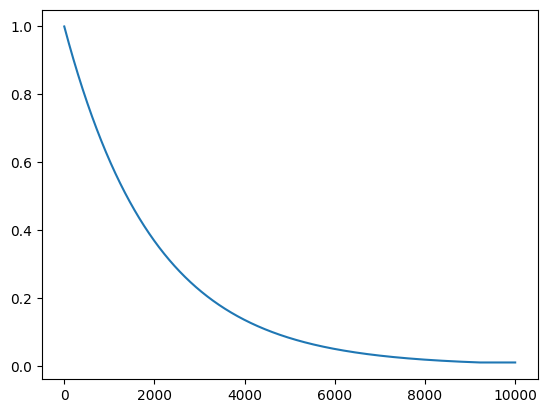

In [4]:
# Hyperparameters (維持不變)
num_episodes = 10000
batch_size = 256
gamma = 0.99
lr = 5e-5
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.9995
memory_capacity = 500000
target_update_freq = 1000
epsilon_list=[]
epsilon=epsilon_start
for i in range(num_episodes):
    epsilon = max(epsilon_end, epsilon * epsilon_decay)
    epsilon_list.append(epsilon)
plt.plot(epsilon_list)

In [5]:
# CNN-based DQN Model
class DQN(nn.Module):
    def __init__(self, num_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Replay buffer
# 用於儲存代理人經驗（狀態、動作、獎勵等）的緩衝區，支援隨機抽樣以打破時間相關性，有助於穩定訓練。
class ReplayMemory:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        # Use deque with a fixed capacity to automatically discard the oldest experience when full.
        # 使用 deque 並設定最大長度，當容量滿時會自動移除最舊的資料。

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        # Store a single transition (experience) in the buffer.
        # 儲存一筆經驗（狀態轉移）進緩衝區。

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        # Randomly sample a batch of transitions to break correlation between consecutive samples.
        # 隨機抽取一批經驗，打破樣本間的時間關聯性，提高訓練穩定性。

        # Unpack each element into separate tensors for network input
        # 將 batch 拆解成分別的 tensor 以供神經網路訓練
        states, actions, rewards, next_states, dones = zip(*batch)
        
        # Convert the sampled data into tensors and move them to the specified device (CPU or GPU)
        # 將抽樣資料轉成 tensor 並移至指定設備（CPU/GPU）
        states = torch.tensor(np.stack(states), dtype=torch.float32, device=device)
        actions = torch.tensor(actions, dtype=torch.int64, device=device)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
        next_states = torch.tensor(np.stack(next_states), dtype=torch.float32, device=device)
        dones = torch.tensor(dones, dtype=torch.float32, device=device)
        
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)
        # Return the current size of the buffer.
        # 回傳緩衝區目前儲存的資料數量。
# Preprocess frames (grayscale and resize to 84x84)
# 預處理影格：轉為灰階並縮放為 84x84

def preprocess_frame(frame):
    # frame 是 numpy array (H, W, 3)，先轉為 PIL Image
    # Input is a color image (RGB), convert to PIL format for easier processing.
    # 輸入是彩色圖像（RGB），轉成 PIL Image 以方便處理。
    image = Image.fromarray(frame)

    # 轉灰階
    # Convert the image to grayscale to reduce input complexity.
    # 將影像轉為灰階，降低輸入維度與計算量。
    image = image.convert('L')

    # resize 成 84x84
    # Resize the image to a standard 84x84 shape, as per DQN convention.
    # 依照 DQN 的慣例將影像統一縮放至 84x84。
    image = image.resize((84, 84), Image.Resampling.BILINEAR)  # or NEAREST, or LANCZOS

    # 轉回 numpy 並正規化
    # Convert back to NumPy and normalize pixel values to [0, 1].
    # 轉回 NumPy 格式並將像素值標準化到 [0, 1]。
    frame = np.asarray(image, dtype=np.float32) / 255.0

    return frame


def stack_frames(stacked_frames, state, is_new_episode):
    # 預處理目前影格
    frame = preprocess_frame(state)

    if is_new_episode or stacked_frames is None:
        # If it's a new episode or no previous frames, initialize with 4 identical frames
        # 若是新的一集或是尚未初始化，則用目前影格複製 4 次形成初始堆疊
        stacked_frames = deque([frame]*4, maxlen=4)
    else:
        # 否則把新影格加入到堆疊中，自動捨棄最舊的
        stacked_frames.append(frame)

    # Stack the 4 frames along the first dimension: shape becomes (4, 84, 84)
    # 沿著第一維（channel）堆疊成 4 通道輸入：形狀變成 (4, 84, 84)
    stacked_state = np.stack(stacked_frames, axis=0)

    return stacked_state, stacked_frames


In [6]:
class SpaceShipEnv():
    def __init__(self, frame_skip=4, stack_frames=4):
        pygame.init()
        # pygame.font.init() # 如果不在 env 中顯示文字，可以不用初始化

        self.screen = None 
        self.clock = pygame.time.Clock()
        self.fps = FPS

        self.game = Game() # 遊戲邏輯實例

        # 動作空間: 0: 不動, 1: 左, 2: 右, 3: 射擊
        self.action_space = [0, 1, 2, 3] 
        self.action_space_n = len(self.action_space)

        # 幀處理相關
        self.frame_skip = frame_skip
        self.stack_frames = stack_frames
        self.frame_buffer = deque(maxlen=self.stack_frames)

        self.frames_since_last_shot = 0
        self.SHOT_COOLDOWN_FRAMES = 60 # 假設子彈冷卻時間為 60 幀
        
        # 定義中間區域的範圍
        self.CENTER_ZONE_WIDTH_PERCENT = 0.5 # 中間 20% 的區域
        self.CENTER_ZONE_X_START = WIDTH * (0.5 - self.CENTER_ZONE_WIDTH_PERCENT / 2)
        self.CENTER_ZONE_X_END = WIDTH * (0.5 + self.CENTER_ZONE_WIDTH_PERCENT / 2)
        # ## 新增: 勝利條件分數 ##
        self.WIN_SCORE = 10000 

    def step(self, action):
        """
        執行一個動作，並回傳 (下一個狀態, 獎勵, 遊戲是否結束, 當前分數)
        """
        total_reward = 0.0
        done = False

        # --- 狀態追蹤 (State Tracking) ---
        # 在 action 執行前，記錄當前的狀態，以便後續計算獎勵
        prev_health = self.game.player.sprite.health
        prev_score = self.game.score
        prev_is_power = self.game.is_power 
        # --- 執行動作 (Action Execution) ---
        # 根據 frame_skip 的設定，重複執行同一個動作
        for _ in range(self.frame_skip):
            self.game.update(action) 
            
            # ## 優化 ##
            # 除非需要渲染畫面來獲取狀態，否則 draw 是不必要的。
            # 這裡假設 self.game.update() 會更新 self.game.state
            # 如果不是，則保留 self.game.draw(None)
            
            # 檢查遊戲是否在任何一幀結束
            if not self.game.running:
                done = True
                break

        # --- 獎勵計算 (Reward Calculation) ---
        # 在所有幀都執行完畢後，根據「狀態的變化」來計算總獎勵
        
        # 1. 主要獎勵：分數增益 (Score Gain)
        current_score = self.game.score
        current_is_power = self.game.is_power # 獲取最新的 is_power 狀態
        current_health = self.game.player.sprite.health # 獲取最新的健康值
        current_is_hit_rock = self.game.is_hit_rock # 獲取最新的是否擊中石頭狀態

        score_gain = current_score - prev_score
        if score_gain > 0:
            # 將分數的增益直接轉換為獎勵，權重可以調整
            # 這樣 Agent 會自然學會優先攻擊分數較高的石頭 (通常更大、更危險)
            total_reward += score_gain * 0.5  # 權重是超參數，可以實驗調整 🎮
            
            # 根據分數增益給予額外的大石頭獎勵，與 1_2 版本對齊
            if score_gain >= 40: # 超大型石頭 (例如半徑 ~40)
                total_reward += 10.0 
            elif score_gain >= 15: # 大型石頭 (例如半徑 ~18)
                total_reward += 5.0 
            elif score_gain >= 5: # 中型石頭
                total_reward += 3 
            else: # 小型石頭
                total_reward += 2 

        # 2. 主要懲罰：生命值損失 (Health Loss)
        health_diff = current_health - prev_health
        if health_diff < 0: # 掉血懲罰
            total_reward -= abs(health_diff) * 10  # 固定的高額懲罰 🩸 (使用 abs 以便計算正數)
        elif health_diff > 0: # 補血獎勵
            total_reward += health_diff * 1.5 # 補血有獎勵！🩹

        # 3. 行為塑造：射擊成本 (Shooting Cost) 及擊中獎勵
        if action == 3: # 假設 3 是射擊
            if self.frames_since_last_shot < self.SHOT_COOLDOWN_FRAMES:
                total_reward -= 2.5 # 冷卻中射擊懲罰大幅提高！❌
            else:
                self.frames_since_last_shot = 0 # 重置射擊冷卻計時器
                if current_is_hit_rock and score_gain > 0: # 射擊並成功擊中石頭並得分
                    total_reward += 10 # 成功射擊本身有小獎勵
                else: # 亂射或沒擊中
                    total_reward -= 5 # 亂射懲罰再高一點 🎯

        # 4. 行為塑造：生存獎勵 (Survival Reward)
        if not done:
            if action == 0:
                total_reward += 0.5
            else:
                total_reward += 0.55
        # 5. 終局獎勵/懲罰 (Terminal Reward/Penalty)
        if done:
            if current_health <= 0: # 因為死亡導致遊戲結束
                total_reward -= 500.0 # 死亡的懲罰，比單次受傷更重！💀
            if current_score >= self.WIN_SCORE: # 勝利條件達成
                total_reward += 10000.0 # 勝利的喜悅！🎉

        # 吃到寶物獎勵
        if current_is_power and not prev_is_power: 
            total_reward += 50 # 吃到寶物給予獎勵 ✨ (調整為 20 以與 1_2 更接近)

        # 中間區域額外獎勵 (調整為與 1_2 相同邏輯)
        ship_center_x = self.game.player.sprite.rect.centerx 
        if ship_center_x >= self.CENTER_ZONE_X_START and \
           ship_center_x <= self.CENTER_ZONE_X_END: # 不再需要判斷是否有最佳射擊目標和子彈準備好
            total_reward += 0.3 # 鼓勵保持在中心 🎯

        # 新增：基於總分數的額外獎勵 (每次 step 都給予，但權重可以很小)
        if self.game.score > 0:
            reward_for_total_score = self.game.score * 0.005 # 舉例值，需要實驗調整！💡
            total_reward += reward_for_total_score

        # --- 狀態處理 (State Processing) ---
        # 這部分邏輯與您原本的設計相同，非常棒！
        current_raw_frame = self.game.state
        processed_frame = preprocess_frame(current_raw_frame)
        self.frame_buffer.append(processed_frame)
        
        # 確保 buffer 在遊戲一開始就能填滿
        while len(self.frame_buffer) < self.stack_frames:
            self.frame_buffer.append(processed_frame)
            
        stacked_state = np.array(list(self.frame_buffer))

        # info 通常是一個字典，可用來傳遞除錯資訊，這裡我們先簡單回傳分數
        info = {'score': self.game.score}

        return stacked_state, total_reward, done, info

    def reset(self):
        # Reset 函數的邏輯很完美，不需要大改
        self.game = Game()
        self.frame_buffer.clear()
        
        # 填充初始的 frame buffer
        for _ in range(self.stack_frames):
            initial_raw_state = self.game.state 
            processed_frame = preprocess_frame(initial_raw_state) 
            self.frame_buffer.append(processed_frame)
        
        stacked_state = np.array(list(self.frame_buffer))
        return stacked_state

    def render(self):
        # Render 函數的邏輯很完美，不需要修改
        if self.screen is None:
            self.screen = pygame.display.set_mode((WIDTH, HEIGHT))
            pygame.display.set_caption("SpaceShip RL Environment")

        # 讓視窗可以被關閉
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                self.close()
                sys.exit()

        self.game.draw(self.screen) 
        pygame.display.update()
        self.clock.tick(self.fps)

    def close(self):
        pygame.quit()

In [7]:
for i in range(50):
    # Hyperparameters (維持不變)
    num_episodes = 10000
    batch_size = 640000000
    gamma = 0.99
    lr = 5e-5
    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 0.9995
    memory_capacity = 500000
    target_update_freq = 1000

    # 初始化 Breakout 環境 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 確保 device 有定義
    env = SpaceShipEnv(frame_skip=2, stack_frames=4) # 明確指定 frame_skip 和 stack_frames
    num_actions = len(env.action_space)

    # 建立策略網路與目標網路
    policy_net = DQN(num_actions).to(device)
    target_net = DQN(num_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict()) 
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = ReplayMemory(memory_capacity)

    # 載入模型（若有）
    if os.path.exists('checkpoint.pth'):
        checkpoint = torch.load('checkpoint.pth', map_location=device)
        policy_net.load_state_dict(checkpoint['policy_net'])
        target_net.load_state_dict(checkpoint['target_net'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_episode = checkpoint['episode'] + 1
        total_steps = checkpoint['total_steps']
        best_score = checkpoint['best_score']
        epsilon = checkpoint['epsilon']
        reward_history = checkpoint['reward_history']
        score_history = checkpoint['score_history']
        print(f"Loaded checkpoint from episode {start_episode}, best score: {best_score:.2f}, epsilon={epsilon:.3f}")
    else:
        start_episode = 0
        total_steps = 0
        best_score = float('-inf')
        epsilon = epsilon_start
        reward_history = []
        score_history = []


    # 訓練迴圈
    for episode in range(start_episode, num_episodes + 1): 
        # env.reset() 現在會直接返回堆疊好的狀態
        state = env.reset() 
        # 移除這行，因為 stacked_frames 不再需要，且 stack_frames 函數已移除
        # state, stacked_frames = stack_frames(None, state, True) 
        total_reward, done = 0, False

        while not done:
            # ε-greedy 策略
            if random.random() < epsilon:
                action = random.choice(env.action_space)
            else:
                with torch.no_grad():
                    # state 已經是 (4, 84, 84)，需要 unsqueeze(0) 變成 (1, 4, 84, 84)
                    state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                    action = policy_net(state_tensor).argmax(dim=1).item()

            # 執行動作，env.step 返回的 next_state 也是堆疊好的狀態
            # ==================== 主要修改處 ====================
            # 執行動作，正確接收 info 字典
            next_state, reward, done_, info = env.step(action)
            # 從 info 字典中提取當前的分數
            score = info['score']
            # ==================================================
            done = done_
            total_reward += reward

            # 移除這行，因為 stacked_frames 不再需要
            # next_state, stacked_frames = stack_frames(stacked_frames, next_state, False) 
            memory.push(state, action, reward, next_state, done)
            state = next_state

            # 訓練模型
            if len(memory) >= batch_size:
                states, actions, rewards, next_states, dones = memory.sample(batch_size)

                with torch.no_grad():
                    target_q = rewards + gamma * target_net(next_states).max(1)[0] * (1 - dones)

                current_q = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                loss = F.mse_loss(current_q, target_q)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # 更新 target 網路
            total_steps += 1
            if total_steps % target_update_freq == 0:
                target_net.load_state_dict(policy_net.state_dict())
            
            if episode % 10 == 0 and total_steps % 4 == 0: # <-- 建議從這裡開始測試
                env.render() 

        # 更新 epsilon 並紀錄統計資料
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        reward_history.append(total_reward)
        score_history.append(score)

        print(f"Episode {episode + 1:3d}, Reward: {total_reward:7.2f}, Score: {score:4d}, Epsilon: {epsilon:5.3f}")

        # 儲存模型
        if (episode + 1) % 200 == 0 or score > best_score:
            best_score = max(best_score, score)

            model_name = f"checkpointV1_6_{episode + 1}_{best_score}.pth"
            torch.save({
                'policy_net': policy_net.state_dict(),
                'target_net': target_net.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epsilon': epsilon,
                'episode': episode,
                'total_steps': total_steps,
                'best_score': best_score,
                'reward_history': reward_history,
                'score_history': score_history,
            }, 'checkpoint.pth')
            torch.save({
                'policy_net': policy_net.state_dict(),
                'target_net': target_net.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epsilon': epsilon,
                'episode': episode,
                'total_steps': total_steps,
                'best_score': best_score,
                'reward_history': reward_history,
                'score_history': score_history,
            }, model_name)

            print(f"Checkpoint saved at episode {episode + 1}, best score: {best_score:.2f}")
            break

    # env.close()

C:\Users\user\AppData\Local\Temp\ipykernel_9388\2492152160.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoint.pth', map_location=device

Loaded checkpoint from episode 1600, best score: 1620.00, epsilon=0.449
Episode 1601, Reward:   66.93, Score:  732, Epsilon: 0.449
Episode 1602, Reward: -873.29, Score:  340, Epsilon: 0.449
Episode 1603, Reward: -1372.54, Score:  134, Epsilon: 0.449
Episode 1604, Reward: 1891.03, Score: 1146, Epsilon: 0.448
Episode 1605, Reward: -484.51, Score:  442, Epsilon: 0.448
Episode 1606, Reward: -731.84, Score:  412, Epsilon: 0.448
Episode 1607, Reward: -1589.72, Score:   74, Epsilon: 0.448
Episode 1608, Reward: -949.13, Score:  364, Epsilon: 0.447
Episode 1609, Reward: -1242.91, Score:  176, Epsilon: 0.447
Episode 1610, Reward: -1227.39, Score:  172, Epsilon: 0.447
Episode 1611, Reward: -1413.87, Score:  118, Epsilon: 0.447
Episode 1612, Reward: -1433.23, Score:  160, Epsilon: 0.447
Episode 1613, Reward: -208.95, Score:  536, Epsilon: 0.446
Episode 1614, Reward:  242.83, Score:  626, Epsilon: 0.446
Episode 1615, Reward: -1429.39, Score:  154, Epsilon: 0.446
Episode 1616, Reward: -786.36, Score

KeyboardInterrupt: 

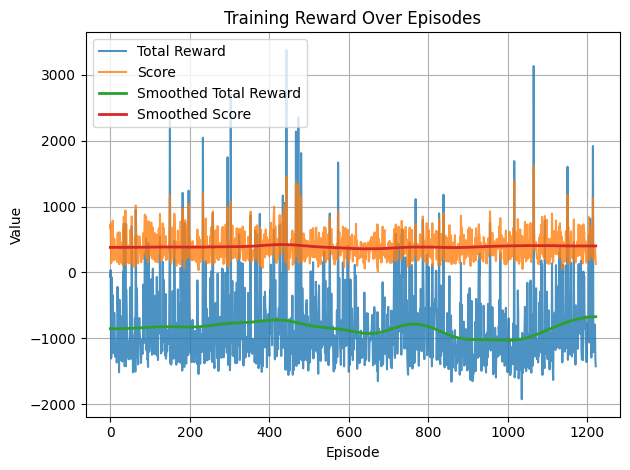

In [11]:
from scipy.ndimage import gaussian_filter1d

reward_smooth = gaussian_filter1d(reward_history, sigma=50)
score_smooth = gaussian_filter1d(score_history, sigma=50)

# 畫圖
# plt.figure(figsize=(10, 5))
plt.plot(reward_history, label='Total Reward', alpha=0.8)
plt.plot(score_history, label='Score', alpha=0.8)
plt.plot(reward_smooth, label='Smoothed Total Reward', linewidth=2)
plt.plot(score_smooth, label='Smoothed Score', linewidth=2)

plt.legend(loc='upper left')
plt.xlabel("Episode")
plt.ylabel("Value")
plt.title("Training Reward Over Episodes")
plt.grid(True)
plt.tight_layout()
# plt.savefig("dqn_training_curve.png")



In [ ]:

# Hyperparameters (維持不變)
num_episodes = 10000
batch_size = 640000000
gamma = 0.99
lr = 5e-5
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.9995
memory_capacity = 500000
target_update_freq = 1000

# 初始化 Breakout 環境 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 確保 device 有定義
env = SpaceShipEnv(frame_skip=2, stack_frames=4) # 明確指定 frame_skip 和 stack_frames
num_actions = len(env.action_space)

# 建立策略網路與目標網路
policy_net = DQN(num_actions).to(device)
target_net = DQN(num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict()) 
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=lr)
memory = ReplayMemory(memory_capacity)

# 載入模型（若有）
if os.path.exists('checkpoint.pth'):
    checkpoint = torch.load('checkpoint.pth', map_location=device)
    policy_net.load_state_dict(checkpoint['policy_net'])
    target_net.load_state_dict(checkpoint['target_net'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_episode = checkpoint['episode'] + 1
    total_steps = checkpoint['total_steps']
    best_score = checkpoint['best_score']
    epsilon = checkpoint['epsilon']
    reward_history = checkpoint['reward_history']
    score_history = checkpoint['score_history']
    print(f"Loaded checkpoint from episode {start_episode}, best score: {best_score:.2f}, epsilon={epsilon:.3f}")
else:
    start_episode = 0
    total_steps = 0
    best_score = float('-inf')
    epsilon = epsilon_start
    reward_history = []
    score_history = []


# 訓練迴圈
for episode in range(start_episode, num_episodes + 1): 
    # env.reset() 現在會直接返回堆疊好的狀態
    state = env.reset() 
    # 移除這行，因為 stacked_frames 不再需要，且 stack_frames 函數已移除
    # state, stacked_frames = stack_frames(None, state, True) 
    total_reward, done = 0, False

    while not done:
        # ε-greedy 策略
        if random.random() < epsilon:
            action = random.choice(env.action_space)
        else:
            with torch.no_grad():
                # state 已經是 (4, 84, 84)，需要 unsqueeze(0) 變成 (1, 4, 84, 84)
                state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                action = policy_net(state_tensor).argmax(dim=1).item()

        # 執行動作，env.step 返回的 next_state 也是堆疊好的狀態
        # ==================== 主要修改處 ====================
        # 執行動作，正確接收 info 字典
        next_state, reward, done_, info = env.step(action)
        # 從 info 字典中提取當前的分數
        score = info['score']
        # ==================================================
        done = done_
        total_reward += reward

        # 移除這行，因為 stacked_frames 不再需要
        # next_state, stacked_frames = stack_frames(stacked_frames, next_state, False) 
        memory.push(state, action, reward, next_state, done)
        state = next_state

        # 訓練模型
        if len(memory) >= batch_size:
            states, actions, rewards, next_states, dones = memory.sample(batch_size)

            with torch.no_grad():
                target_q = rewards + gamma * target_net(next_states).max(1)[0] * (1 - dones)

            current_q = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            loss = F.mse_loss(current_q, target_q)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # 更新 target 網路
        total_steps += 1
        if total_steps % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())
        
        if episode % 10 == 0 and total_steps % 4 == 0: # <-- 建議從這裡開始測試
            env.render() 

    # 更新 epsilon 並紀錄統計資料
    epsilon = max(epsilon_end, epsilon * epsilon_decay)
    reward_history.append(total_reward)
    score_history.append(score)

    print(f"Episode {episode + 1:3d}, Reward: {total_reward:7.2f}, Score: {score:4d}, Epsilon: {epsilon:5.3f}")

    # 儲存模型
    if (episode + 1) % 200 == 0 or score > best_score:
        best_score = max(best_score, score)

        model_name = f"checkpointV1_6_{episode + 1}_{best_score}.pth"
        torch.save({
            'policy_net': policy_net.state_dict(),
            'target_net': target_net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epsilon': epsilon,
            'episode': episode,
            'total_steps': total_steps,
            'best_score': best_score,
            'reward_history': reward_history,
            'score_history': score_history,
        }, 'checkpoint.pth')
        torch.save({
            'policy_net': policy_net.state_dict(),
            'target_net': target_net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epsilon': epsilon,
            'episode': episode,
            'total_steps': total_steps,
            'best_score': best_score,
            'reward_history': reward_history,
            'score_history': score_history,
        }, model_name)

        print(f"Checkpoint saved at episode {episode + 1}, best score: {best_score:.2f}")
        break

# env.close()